In [1]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from celluloid import Camera
from func_data_generation import *
from func_polygon import *
from torch import nn
from utils import *
from warp_units import *

# from torchsummary import summary


dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

Using cuda device


In [2]:
class ScaleToBounds(torch.nn.Module):
    """
    Scale the input data so that it lies in between the lower and upper bounds.

    In training (`self.train()`), this module adjusts the scaling factor to the minibatch of data.
    During evaluation (`self.eval()`), this module uses the scaling factor from the previous minibatch of data.

    :param float lower_bound: lower bound of scaled data
    :param float upper_bound: upper bound of scaled data

    Example:
        >>> train_x = torch.randn(10, 5)
        >>> module = gpytorch.utils.grid.ScaleToBounds(lower_bound=-1., upper_bound=1.)
        >>>
        >>> module.train()
        >>> scaled_train_x = module(train_x)  # Data should be between -0.95 and 0.95
        >>>
        >>> module.eval()
        >>> test_x = torch.randn(10, 5)
        >>> scaled_test_x = module(test_x)  # Scaling is based on train_x
    """

    def __init__(self, lower_bound, upper_bound):
        super().__init__()
        self.lower_bound = float(lower_bound)
        self.upper_bound = float(upper_bound)
        self.register_buffer("min_val", torch.tensor(lower_bound))
        self.register_buffer("max_val", torch.tensor(upper_bound))

    def forward(self, x):
        if self.training:
            min_val = x.min()
            max_val = x.max()
            self.min_val.data = min_val
            self.max_val.data = max_val
        else:
            min_val = self.min_val
            max_val = self.max_val
            # Clamp extreme values
            x = x.clamp(min_val, max_val)

        diff = max_val - min_val
        x = (x - min_val) * (
            0.95 * (self.upper_bound - self.lower_bound) / diff
        ) + 0.95 * self.lower_bound
        return x

In [3]:
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy


class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module(
            "axial_dim0", AxialWarpUnit(dim=0, res=20, grad=20, lims=[0, 1.0])
        )
        self.add_module(
            "axial_dim1", AxialWarpUnit(dim=1, res=20, grad=20, lims=[-1.0, 0])
        )
        #         self.add_module("rbf_seq1", rbfunit_sequential(res=1, ylim=[-1.0, 0.0]))
        self.add_module("rbf_seq2", rbfunit_sequential(res=2, ylim=[-1.0, 0.0]))

        #         self.add_module("rbf_seq3", rbfunit_sequential(res=3, ylim=[-1, 0]))

        self.add_module("mobius", MobiusWarpUnit())


class InducingWarpGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super(InducingWarpGP, self).__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean()
        #         self.mean_module = QuodralMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.space_transform = warp_model
        self.scale_to_bounds = ScaleToBounds(0, 1)

    def forward(self, x):
        projected_x = self.space_transform(x)
        projected_x = self.scale_to_bounds(projected_x)

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
data_num = 1
sensor_num = 1000  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"

if os.path.exists(data_filename):
    with h5py.File(data_filename, "r") as f1:
        coords = f1["coords"][...]
        true_rss = f1["shadow"][...]
        observed_rss = f1["observed_rss"][...]
        train_X = f1["train_" + str(sensor_num) + "/train_X"][...]
        train_y = f1["train_" + str(sensor_num) + "/train_y"][...]
        idx = f1["train_" + str(sensor_num) + "/idx"][...]

In [5]:
# Normalize train_X to 0-1
train_X_tensor = torch.from_numpy(train_X).to(device) / 1000
coords_tensor = torch.from_numpy(coords).to(device) / 1000

train_y_tensor = torch.from_numpy(train_y).to(device)
true_rss_tensor = torch.from_numpy(true_rss).to(device)
# train_y_mean = train_y_tensor.mean()
# train_y_tensor = train_y_tensor - train_y_mean
# train_y_sigma = torch.sqrt(train_y_tensor.var())
# train_y_tensor = (train_y_tensor - train_y_mean) / train_y_sigma

In [6]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(coords_tensor, true_rss_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
x_ = torch.linspace(0, 1, 10)
y_ = torch.linspace(-1, 0, 10)
x, y = torch.meshgrid(
    x_,
    y_,
)
inducing_points = torch.stack((x.flatten(), y.flatten()), dim=-1).to(device)

warp_model = WarpModel().to(device)
model = InducingWarpGP(inducing_points=inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

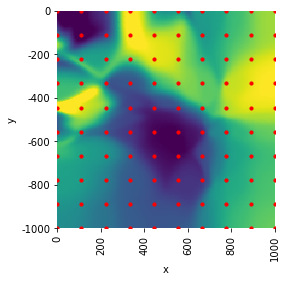

In [8]:
fig, ax = plt.subplots()
plot_heatmap(coords, true_rss, ax=ax, cbar=False, robust=True)
ax.scatter(
    inducing_points.cpu().numpy()[:, 0] * 180,
    inducing_points.cpu().numpy()[:, 1] * -180,
    c="r",
    s=10,
)

In [9]:
for name, param in model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

Layer:variational_strategy.inducing_points | Size:torch.Size([100, 2]) | Values : Parameter containing:
tensor([[ 0.0000, -1.0000],
        [ 0.0000, -0.8889],
        [ 0.0000, -0.7778],
        [ 0.0000, -0.6667],
        [ 0.0000, -0.5556],
        [ 0.0000, -0.4444],
        [ 0.0000, -0.3333],
        [ 0.0000, -0.2222],
        [ 0.0000, -0.1111],
        [ 0.0000,  0.0000],
        [ 0.1111, -1.0000],
        [ 0.1111, -0.8889],
        [ 0.1111, -0.7778],
        [ 0.1111, -0.6667],
        [ 0.1111, -0.5556],
        [ 0.1111, -0.4444],
        [ 0.1111, -0.3333],
        [ 0.1111, -0.2222],
        [ 0.1111, -0.1111],
        [ 0.1111,  0.0000],
        [ 0.2222, -1.0000],
        [ 0.2222, -0.8889],
        [ 0.2222, -0.7778],
        [ 0.2222, -0.6667],
        [ 0.2222, -0.5556],
        [ 0.2222, -0.4444],
        [ 0.2222, -0.3333],
        [ 0.2222, -0.2222],
        [ 0.2222, -0.1111],
        [ 0.2222,  0.0000],
        [ 0.3333, -1.0000],
        [ 0.3333, -0.8889],


In [10]:
optimizer = torch.optim.Adam(
    [
        {"params": model.parameters()},
        {"params": likelihood.parameters()},
    ],
    lr=0.01,
)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y_tensor.size(0))


def train(num_epochs):
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    camera = Camera(fig)

    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for i in epochs_iter:
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
        if i % 10 == 1:
            inducing = model.variational_strategy.inducing_points.cpu().detach().numpy()
            ax.scatter(inducing[:, 0], inducing[:, 1], c="r", s=3)
            camera.snap()
    return camera


def train_test(num_epochs):
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    camera = Camera(fig)

    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for i in epochs_iter:
        model.train()
        likelihood.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
        if i % 10 == 1:

            likelihood.eval()
            model.eval()
            means = torch.tensor([])
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    preds = model(x_batch)
                    means = torch.cat([means, preds.mean.cpu().detach()])

            plot_heatmap(coords, means, ax=ax, cbar=False, robust=True)

            inducing = model.variational_strategy.inducing_points.cpu().detach().numpy()
            ax.scatter(inducing[:, 0] * 180, inducing[:, 1] * -180, c="r", s=10)

            camera.snap()
    return camera

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 3h 37min 19s, sys: 2min 54s, total: 3h 40min 14s
Wall time: 3h 40min


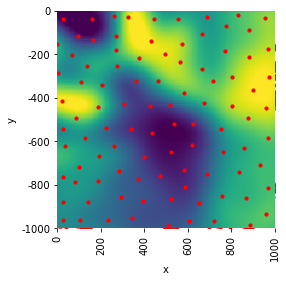

In [11]:
model.train()
likelihood.train()

%time cam = train_test(10000)

In [13]:
model.eval()
likelihood.eval()
means = torch.tensor([])
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])

In [14]:
means

tensor([-7.0455, -7.2552, -7.4436,  ...,  3.6093,  3.5690,  3.5210])

In [67]:
a = model.variational_strategy.inducing_points.cpu().detach().numpy()

In [69]:
a.shape

(100, 2)

In [12]:
animation = cam.animate()
from IPython.display import HTML

HTML(animation.to_html5_video())

In [11]:
animation.save("gp_inducing.gif")

In [30]:
x_ = torch.linspace(0, 1, 10)
y_ = torch.linspace(-1, 0, 10)
x, y = torch.meshgrid(
    x_,
    y_,
)

In [54]:
epochs_iter = tqdm.notebook.tqdm(range(10), desc="Epoch")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]